In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing, tree
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans, vq
from sklearn.model_selection import train_test_split
import pydotplus
from IPython.display import Image

In [2]:
# Import data
df = pd.read_csv('cleaned_data.csv')

# Split the data frame into input and target data frames
X = df.ix[:, df.columns != 'fraud']
y = df.ix[:, df.columns == 'fraud']

# Shuffle and partition our data into 80% train data and 20% test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Use undersampling to create a balanced set
# Number of data points in the minority class
number_records_fraud = len(y_train[y_train['fraud'] == 1])
fraud_indices = np.array(y_train[y_train['fraud'] == 1].index)

# Picking the indices of the normal classes
normal_indices = y_train[y_train['fraud'] == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'fraud']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'fraud']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data['fraud'] == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data['fraud'] == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  4204


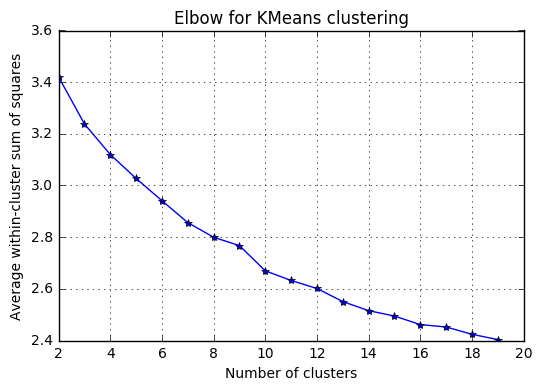

In [3]:
# Create a Scree plot to determine the number of clusters to use
z = preprocessing.scale(X_undersample)
X = np.array(z).astype(float)

K = range(2, 20)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids
avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

In [4]:

clf = KMeans(n_clusters=6)
results = clf.fit(z)
X_undersample['cluster'] = pd.Series(clf.predict(z), index=X_undersample.index)
pd.crosstab(X_undersample['cluster'], y_undersample['fraud']).transpose()

cluster,0,1,2,3,4,5
fraud,,,,,,
0,391,387,694,602,27,1
1,322,549,384,313,29,505


In [5]:

clf = KMeans(n_clusters=35)
results = clf.fit(z)
X_undersample['cluster'] = pd.Series(clf.predict(z), index=X_undersample.index)
pd.crosstab(X_undersample['cluster'], y_undersample['fraud'])

fraud,0,1
cluster,,
0,75,106
1,1,178
2,53,68
3,82,55
4,27,29
5,58,37
6,73,46
7,104,20
8,114,29


In [6]:
df2 = X_undersample

cluster = []

for i in df2['cluster']:
    if i == 33:
        cluster.append(1)
    else:
        cluster.append(0)
        
df2['cluster'] = cluster

In [7]:
X = np.array(df2.drop(['cluster'], 1))
y = np.array(df2['cluster'])
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

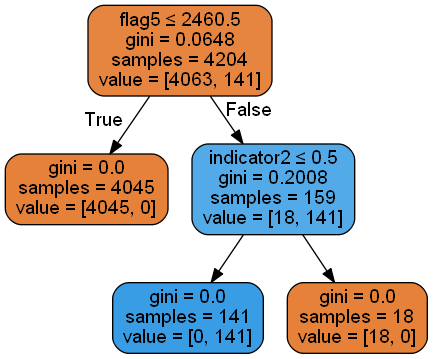

In [8]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names = df2.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())